## Pneumonia Detection from Chest X-ray Images

In this notebook, a `Convolutional Neural Network (CNN)` is built and trained that aims to setect the presence of `pneumonia` disease by analyzing chest X-ray images.

This is a `binary classification` problem where, the outcome would be either a person has `pneumonia` disease or not (`normal`).

This model is bulit from scratch i.e. not relying on transfer learning approaches (pre-trained models).

### Importing the libraries

In [25]:
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D, \
    Dense, Flatten, BatchNormalization, Dropout
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator

### Configurations to be used later

In [9]:
MODEL_LOC = '../model/pneumonia_detection_cnn_model.h5'
DATA_DIR = '../data/'
TRAINING_DATA_DIR = DATA_DIR + '/train/'
TEST_DATA_DIR = DATA_DIR + '/test/'
DETECTION_CLASSES = ('NORMAL', 'PNEUMONIA')
BATCH_SIZE = 32
EPOCHS = 100

### Exploratory Data Analysis (EDA)

As can be seen from the above data exploration, the data is highly imbalanced. The number of images for `pneumonia`cases are much higher than the `normal` images. However, this is expected in the medical data, as a person is advised to have the X-ray done if some symptoms are noticed and hence more likely to have the disease.

### Preparing the data

In [10]:
# data generator on training dataset, data augmentation applied
train_datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        shear_range=0.2,
        vertical_flip=True,
        rotation_range=10,
        zoom_range=0.3)
# preprocessing the training set
training_dataset = train_datagen.flow_from_directory(TRAINING_DATA_DIR,
                                                         classes=DETECTION_CLASSES,
                                                         shuffle=True,
                                                         batch_size=BATCH_SIZE,
                                                         target_size=(224, 224))
# data generator on test dataset (here used as validation)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# preprocessing the test set (here used as validation)
test_dataset = test_datagen.flow_from_directory(TEST_DATA_DIR,
                                                    classes=DETECTION_CLASSES,
                                                    shuffle=False,
                                                    batch_size=BATCH_SIZE,
                                                    target_size=(224, 224))


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Building the model

The following model consists of five convolution blocks where after each block, a pooling layer (maxpooling) is added. The flattening layer after the last convolution block prepares the input to be fed into the fully connected layers. In each fully connected layer, Dense method is used to add a hidden layer where units represents the the number of nodes/neurons in that layer. The last fully connected layer has two nodes representing the two cases - `pneumonia` and `normal` where the softmax` activation function is in action.


In [11]:
cnn_model = Sequential()

# First Block of CNN
cnn_model.add(Conv2D(16, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
cnn_model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

#  Second Block of CNN
cnn_model.add(SeparableConv2D(32, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(32, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))

#  Third Block of CNN
cnn_model.add(SeparableConv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))

#  Fourth Block of CNN
cnn_model.add(SeparableConv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(rate=0.2))

#  Fifth Block of CNN
cnn_model.add(SeparableConv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(rate=0.2))

#  Flatten and Fully Connected Layer
cnn_model.add(Flatten())
cnn_model.add(Dense(units=512, activation='relu'))
cnn_model.add(Dropout(rate=0.7))
cnn_model.add(Dense(units=128, activation='relu'))
cnn_model.add(Dropout(rate=0.5))
cnn_model.add(Dense(units=64, activation='relu'))
cnn_model.add(Dropout(rate=0.3))

#  Softmax Classifier
cnn_model.add(Dense(units=2, activation='softmax'))

#  Display model
cnn_model.summary()

# compile model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 112, 112, 32)      688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 112, 112, 32)      1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0

### Training the model


In [12]:
# introducing callbacks
early_stop = EarlyStopping(monitor='val_loss',
                            patience=10,
                            mode='min',
                            min_delta=0.001,
                            restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=MODEL_LOC,  # saves the 'best' model
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

In [ ]:
# fit the model
history = cnn_model.fit(training_dataset,
                        steps_per_epoch=len(training_dataset),
                        validation_data=test_dataset,
                        validation_steps=len(test_dataset),
                        epochs=EPOCHS,
                        callbacks=[early_stop, checkpoint],
                        verbose=1)

### Plot the training history

In [ ]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Model Evaluation

In [26]:
# load the trained CNN model
cnn_model = load_model(MODEL_LOC)

In [27]:
# data generator on test dataset (no data augmentation applied)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# preprocessing the test set
test_dataset = test_datagen.flow_from_directory(TEST_DATA_DIR,
                                                target_size=(224, 224),
                                                classes=DETECTION_CLASSES,
                                                shuffle=False,
                                                batch_size=BATCH_SIZE)

Found 624 images belonging to 2 classes.


In [28]:
# storing the true classes of the test dataset
y_true = test_dataset.classes

# predicting the classes of the test dataset
y_pred = cnn_model.predict(test_dataset, steps=len(test_dataset), verbose=1)

# Storing the predicted probability
y_pred_prob = y_pred[:, 1]

# Storing the binary classes for the predictions
y_pred_binary = y_pred_prob > 0.5

20/20 [==============================] - 11s 516ms/step

In [34]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve

In [40]:
# confusion Matrix
print('\nConfusion Matrix\n -------------------------')
cm = confusion_matrix(y_true, y_pred_binary)
print(cm)


Confusion Matrix
 -------------------------
[[184  50]
 [ 31 359]]


Text(0.5, 1.0, 'Confusion Matrix')

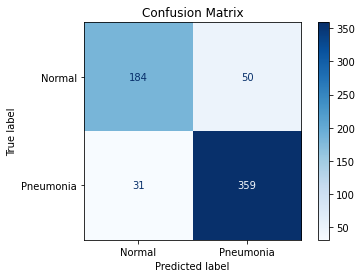

In [41]:
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
cm_display.plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')

In [36]:
# classification report
# accuracy: (tp + tn) / (p + n)
# precision tp / (tp + fp)
# recall: tp / (tp + fn)
# f1_score: 2 tp / (2 tp + fp + fn)
print('\nClassification Report\n -------------------------')
print(classification_report(y_true, y_pred_binary))


Classification Report
 -------------------------
              precision    recall  f1-score   support

           0       0.86      0.79      0.82       234
           1       0.88      0.92      0.90       390

    accuracy                           0.87       624
   macro avg       0.87      0.85      0.86       624
weighted avg       0.87      0.87      0.87       624



In [37]:
# ROC AUC
auc = roc_auc_score(y_true, y_pred_prob)
print('ROC AUC: %f' % auc)


ROC AUC: 0.933640


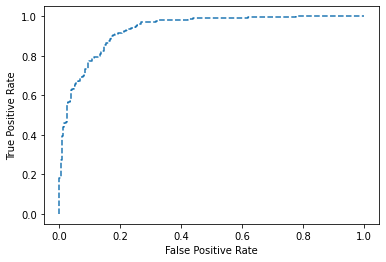

In [38]:
# calculate roc curves
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)

# plot the roc curve for the model
plt.figure()
plt.plot(fpr, tpr, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()